<a href="https://colab.research.google.com/github/mariia-8/Inventory-Forecasting/blob/main/Linear_Regression_Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
from google.colab import files

In [2]:
uploaded = files.upload()

Saving cleaned_store.csv to cleaned_store.csv


In [77]:
df = pd.read_csv('cleaned_store.csv')

In [78]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [79]:
# Extract month from date
df['Year_Month'] = df['InvoiceDate'].dt.to_period('M')

In [80]:
# Group data by month and product
monthly_sales = df.groupby(['StockCode', 'Year_Month']).agg(
    Total_Quantity=('Quantity', 'sum'),
    Average_Price=('Price', 'mean')
).reset_index()

In [81]:
# Found one outlier in price, removed it
monthly_sales = monthly_sales[monthly_sales['Average_Price'] < 250]

In [82]:
monthly_sales.sort_values(by=['StockCode', 'Year_Month'], ascending=[True, True], inplace=True)

In [83]:
# Monthly sales for each product
monthly_sales.head()

,StockCode,Year_Month,Total_Quantity,Average_Price
0,10002,2009-12,212,0.850000
1,10002,2010-01,289,0.850000
2,10002,2010-02,255,0.850000
3,10002,2010-03,633,0.817500
4,10002,2010-04,1129,0.819048


In [84]:
monthly_sales['Log_Total_Quantity'] = monthly_sales['Total_Quantity'].apply(lambda x: np.log(x+1) if x > 0 else 0)

In [85]:
# Sales quantity from previous month for each product
monthly_sales['Lagged_Quantity_1m'] = monthly_sales.groupby('StockCode')['Log_Total_Quantity'].shift(1)

In [86]:
monthly_sales.dropna(inplace=True)

In [87]:
monthly_sales.head()

,StockCode,Year_Month,Total_Quantity,Average_Price,Log_Total_Quantity,Lagged_Quantity_1m
1,10002,2010-01,289,0.850000,5.669881,5.361292
2,10002,2010-02,255,0.850000,5.545177,5.669881
3,10002,2010-03,633,0.817500,6.452049,5.545177
4,10002,2010-04,1129,0.819048,7.029973,6.452049
5,10002,2010-05,1409,0.832069,7.251345,7.029973


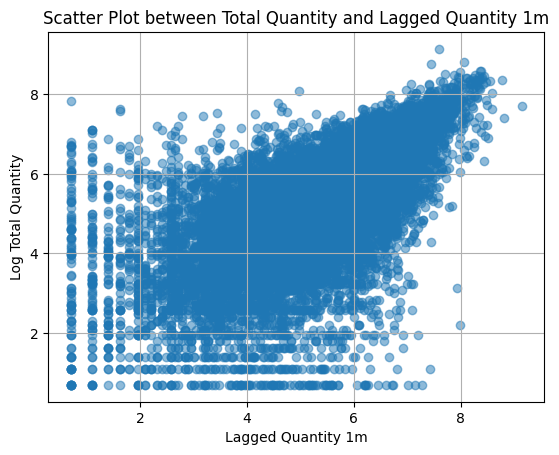

In [88]:
# Relationship between total quantity and total quantity from previous month
plt.scatter(monthly_sales['Lagged_Quantity_1m'], monthly_sales['Log_Total_Quantity'], alpha=0.5)
plt.title('Scatter Plot between Total Quantity and Lagged Quantity 1m')
plt.xlabel('Lagged Quantity 1m')
plt.ylabel('Log Total Quantity')
plt.grid(True)
plt.show()

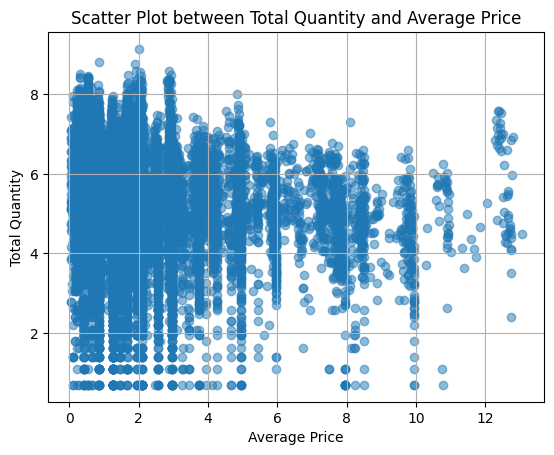

In [89]:
# Relationship between total quantity and average price
plt.scatter(monthly_sales['Average_Price'], monthly_sales['Log_Total_Quantity'], alpha=0.5)
plt.title('Scatter Plot between Total Quantity and Average Price')
plt.xlabel('Average Price')
plt.ylabel('Total Quantity')
plt.grid(True)
plt.show()

In [90]:
# Seasonality features - month
monthly_sales['time_month'] = monthly_sales['Year_Month'].dt.month

In [91]:
monthly_sales = pd.get_dummies(monthly_sales, columns=['time_month'], prefix='month')
for month in range(1, 13):
    column_name = f'month_{month}'
    monthly_sales[column_name] = monthly_sales[column_name].astype(int)


In [92]:
monthly_sales['time_trend'] = monthly_sales['Year_Month'].dt.month

In [93]:
corr_df = monthly_sales[['Total_Quantity', 'time_trend','Average_Price', 'Lagged_Quantity_1m', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11']]

In [94]:
correlation_matrix = corr_df.corr()

In [95]:
# Correlation of y and features
correlation_matrix

,Total_Quantity,time_trend,Average_Price,Lagged_Quantity_1m,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
Total_Quantity,1.000000,0.073479,-0.106290,0.537759,-0.043946,-0.043252,-0.002705,-0.028926,-0.005775,-0.002652,-0.025140,-0.012154,0.038981,0.077685,0.131243
time_trend,0.073479,1.000000,-0.006587,0.142770,-0.470836,-0.394695,-0.317542,-0.239076,-0.156285,-0.072610,0.015342,0.106925,0.201305,0.298514,0.394653
Average_Price,-0.106290,-0.006587,1.000000,-0.102444,0.002952,0.006038,0.005117,0.001924,0.001824,0.000579,-0.006975,-0.007409,-0.003999,-0.001160,0.001150
Lagged_Quantity_1m,0.537759,0.142770,-0.102444,1.000000,-0.031009,-0.046673,-0.054091,0.005013,-0.043790,-0.017798,-0.028450,-0.039294,-0.020424,0.048214,0.080391
month_1,-0.043946,-0.470836,0.002952,-0.031009,1.000000,-0.077036,-0.078161,-0.079643,-0.080518,-0.082497,-0.084907,-0.086123,-0.087433,-0.088758,-0.089206
month_2,-0.043252,-0.394695,0.006038,-0.046673,-0.077036,1.000000,-0.079087,-0.080587,-0.081473,-0.083475,-0.085914,-0.087144,-0.088470,-0.089811,-0.090263
month_3,-0.002705,-0.317542,0.005117,-0.054091,-0.078161,-0.079087,1.000000,-0.081764,-0.082662,-0.084694,-0.087169,-0.088416,-0.089762,-0.091122,-0.091582
month_4,-0.028926,-0.239076,0.001924,0.005013,-0.079643,-0.080587,-0.081764,1.000000,-0.084230,-0.086301,-0.088822,-0.090093,-0.091465,-0.092850,-0.093319
month_5,-0.005775,-0.156285,0.001824,-0.043790,-0.080518,-0.081473,-0.082662,-0.084230,1.000000,-0.087249,-0.089798,-0.091083,-0.092469,-0.093870,-0.094344
month_6,-0.002652,-0.072610,0.000579,-0.017798,-0.082497,-0.083475,-0.084694,-0.086301,-0.087249,1.000000,-0.092005,-0.093322,-0.094742,-0.096178,-0.096663


In [96]:
# VIF index - check for multi-collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = monthly_sales[['Average_Price', 'Lagged_Quantity_1m', 'time_trend','month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11']]
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

              Variable        VIF
0        Average_Price   1.011175
1   Lagged_Quantity_1m   1.045881
2           time_trend  13.917332
3              month_1   2.084719
4              month_2   1.884675
5              month_3   1.732002
6              month_4   1.709367
7              month_5   1.551577
8              month_6   1.537876
9              month_7   1.521327
10             month_8   1.538288
11             month_9   1.617419
12            month_10   1.749013
13            month_11   1.886290


In [97]:
# Test/train split (train all 2010, test all 2011)
data_2010 = monthly_sales[monthly_sales['Year_Month'].dt.year == 2010]
data_2011 = monthly_sales[monthly_sales['Year_Month'].dt.year == 2011]

In [98]:
print("Number of rows in 2010:", len(data_2010))
print("Number of rows in 2011:", len(data_2011))

Number of rows in 2010: 8989
Number of rows in 2011: 10814


In [99]:
x_train = data_2010[['Average_Price','Lagged_Quantity_1m', 'time_trend','month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11']]
y_train= data_2010['Log_Total_Quantity']

In [100]:
x_test = data_2011[['Average_Price','Lagged_Quantity_1m', 'time_trend', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11']]

In [101]:
y_test = data_2011['Log_Total_Quantity']

In [102]:
import statsmodels.api as sm

In [103]:
# Multi - linear regression
x_train = sm.add_constant(x_train)
model = sm.OLS(y_train, x_train).fit()

In [104]:
# Summary of regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Log_Total_Quantity   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     546.6
Date:                Fri, 24 May 2024   Prob (F-statistic):               0.00
Time:                        22:32:57   Log-Likelihood:                -12065.
No. Observations:                8989   AIC:                         2.416e+04
Df Residuals:                    8975   BIC:                         2.426e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  1.8303      0

In [105]:
y_pred = model.predict(sm.add_constant(x_test))

In [106]:
y_pred_train = model.predict(sm.add_constant(x_train))

In [107]:
residuals_train = y_train - y_pred_train

In [108]:
residuals_test = y_test - y_pred

In [109]:
data_2011['Predicted_Value_LR'] = y_pred

<ipython-input-109-b28e6fd3f1e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2011['Predicted_Value_LR'] = y_pred


In [110]:
data_2011['Year_Month'] = data_2011['Year_Month'].dt.to_timestamp()

<ipython-input-110-bd869a2b92d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2011['Year_Month'] = data_2011['Year_Month'].dt.to_timestamp()


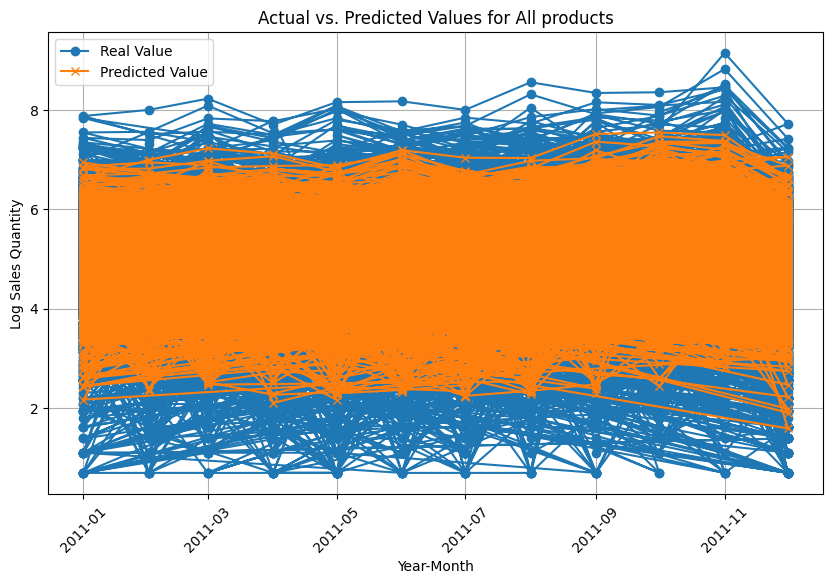

In [111]:
# Predictions vs Actual values
plt.figure(figsize=(10, 6))
plt.plot(data_2011['Year_Month'], data_2011['Log_Total_Quantity'], label='Real Value', marker='o')
plt.plot(data_2011['Year_Month'], data_2011['Predicted_Value_LR'], label='Predicted Value', marker='x')
plt.xlabel('Year-Month')
plt.ylabel('Log Sales Quantity')
plt.title('Actual vs. Predicted Values for All products')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

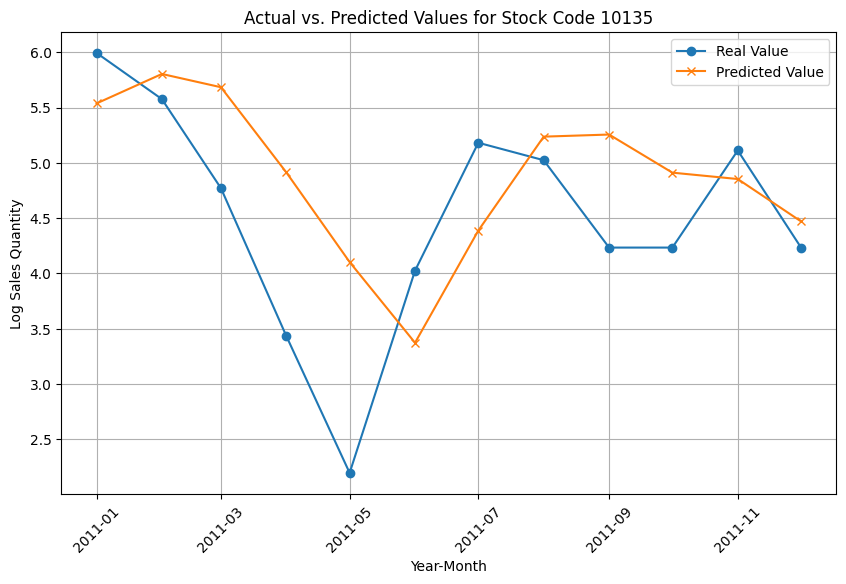

In [112]:
product_pred = data_2011[data_2011['StockCode'] == '10135']
plt.figure(figsize=(10, 6))
plt.plot(product_pred['Year_Month'], product_pred['Log_Total_Quantity'], label='Real Value', marker='o')
plt.plot(product_pred['Year_Month'], product_pred['Predicted_Value_LR'], label='Predicted Value', marker='x')
plt.xlabel('Year-Month')
plt.ylabel('Log Sales Quantity')
plt.title('Actual vs. Predicted Values for Stock Code 10135')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

In [113]:
# Cross Validation for Multi Linear Regression Model
from sklearn.model_selection import TimeSeriesSplit
# Time Series Cross Validation for RF
monthly_sales_date = monthly_sales.copy()
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse_scores = []
mae_scores = []
mape_scores = []

# Iterate over train-test splits and train models
for train_index, test_index in tscv.split(monthly_sales_date):
    train_data, test_data = monthly_sales_date.iloc[train_index], monthly_sales_date.iloc[test_index]

    # Separate features and target variable for training data
    x_train = train_data[['Average_Price', 'Lagged_Quantity_1m', 'time_trend', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11']]
    y_train = train_data['Log_Total_Quantity']

    # Fit Random Forest model
    x_train = sm.add_constant(x_train)
    model = sm.OLS(y_train, x_train).fit()

    # Make predictions
    x_test = test_data[['Average_Price', 'Lagged_Quantity_1m', 'time_trend', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11']]
    predictions = model.predict(sm.add_constant(x_test))

    # Calculate Mean Squared Error
    y_test = test_data['Log_Total_Quantity']
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    mse_scores.append(mse)
    mae_scores.append(mae)
    mape_scores.append(mape)

    print(f'Mean Squared Error for current split: {mse}')

# Calculate average Mean Squared Error across all splits
average_mse = np.mean(mse_scores)
average_mae = np.mean(mae_scores)
average_mape = np.mean(mape_scores)
print(f'Average MSE: {average_mse}')
print(f'Average MAE: {average_mae}')
print(f'Average MAPE: {average_mape}')

Mean Squared Error for current split: 0.9319276072725535
Mean Squared Error for current split: 0.9633849017312439
Mean Squared Error for current split: 0.9246849811880758
Mean Squared Error for current split: 0.8141048263933893
Mean Squared Error for current split: 1.006891919846585
Average MSE: 0.9281988472863695
Average MAE: 0.6865971779044285
Average MAPE: 19.52761991749852


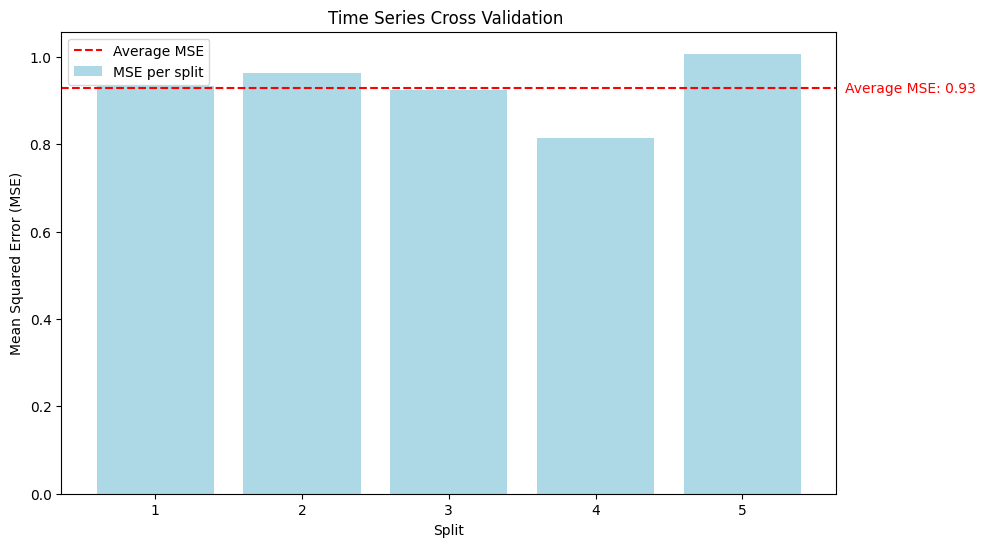

In [114]:
mse_scores = [0.9319276072725535, 0.9633849017312439, 0.9246849811880758, 0.8141048263933893, 1.006891919846585]

# Calculate average MSE across all splits
average_mse = np.mean(mse_scores)

# Plotting bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(1,len(mse_scores)+1), mse_scores, color='lightblue', label='MSE per split')
plt.axhline(average_mse, color='red', linestyle='--', label='Average MSE')
plt.xlabel('Split')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Time Series Cross Validation ')
plt.text(len(mse_scores) + 0.7, average_mse, f'Average MSE: {average_mse:.2f}', color='red', va='center')
plt.legend()
plt.show()

In [115]:
# Diagnostic plots

In [116]:
import seaborn as sns

<Axes: >

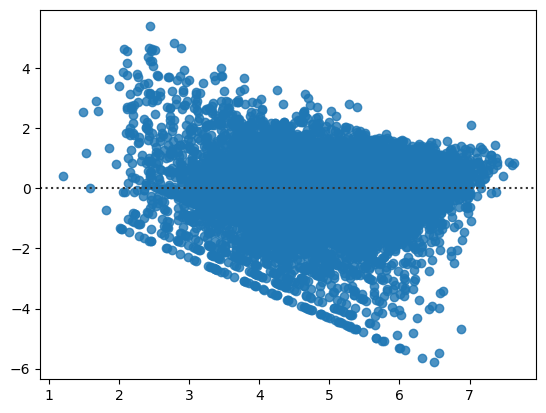

In [117]:
sns.residplot(x=model.fittedvalues, y=model.resid)

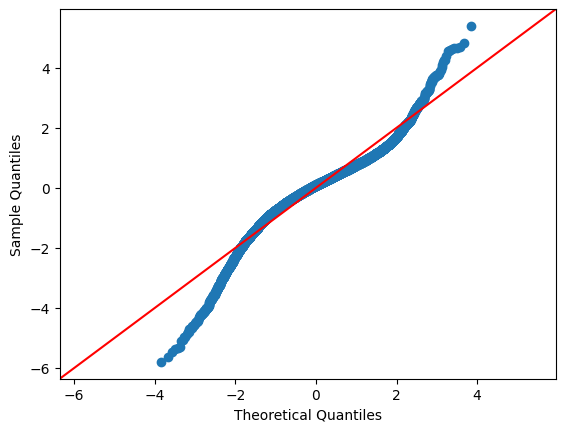

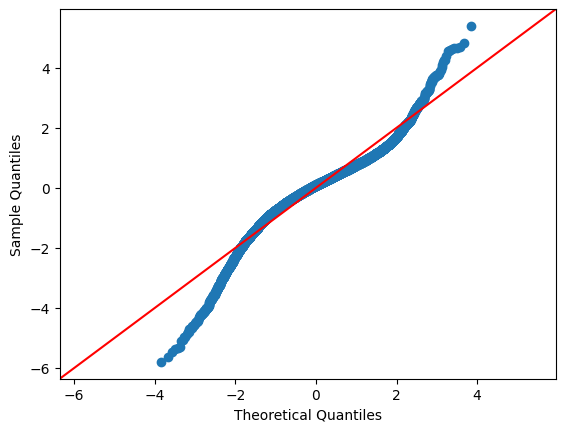

In [118]:
sm.qqplot(model.resid, line='45')

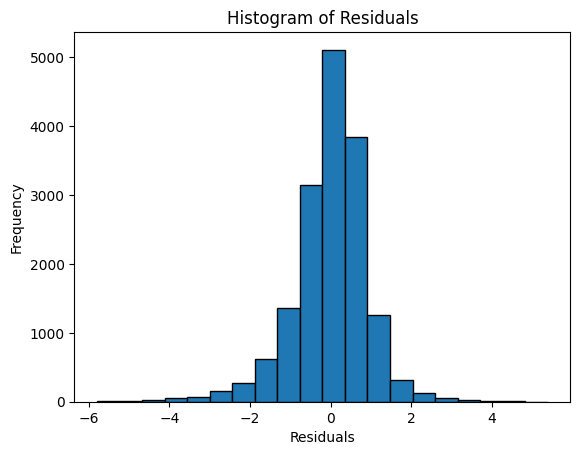

In [119]:
plt.hist(model.resid, bins=20, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

<Axes: >

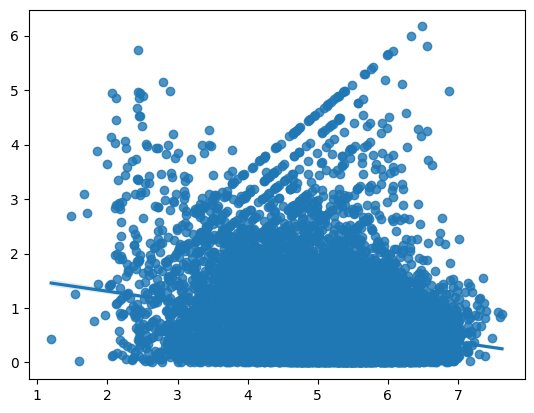

In [120]:
sns.regplot(x=model.fittedvalues, y=abs(model.get_influence().resid_studentized_internal))

In [121]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

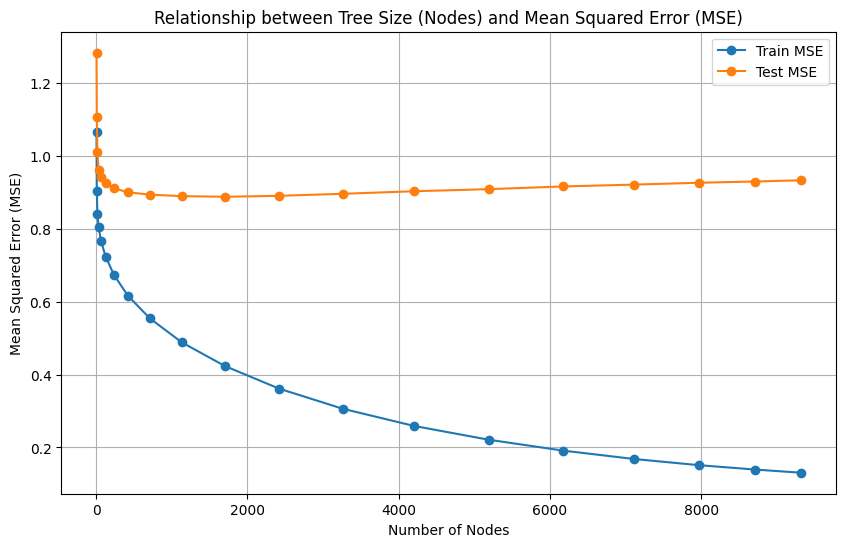

In [122]:
#Fitting graph
max_depth_range = range(1, 21)  # Example range for max_depth
x_train = data_2010[['Average_Price','Lagged_Quantity_1m','time_trend','month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11']]
y_train= data_2010['Log_Total_Quantity']
x_test = data_2011[['Average_Price','Lagged_Quantity_1m', 'time_trend', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11']]
y_test = data_2011['Log_Total_Quantity']
max_depth_list = []
train_mse_list = []
test_mse_list = []
for max_depth in max_depth_range:
    # Instantiate Random Forest regressor with current maximum depth
    rf = RandomForestRegressor(max_depth=max_depth, random_state=42)

    # Train the model
    rf.fit(x_train, y_train)

    # Calculate the total number of nodes in the forest (average across trees)
    total_nodes = sum(estimator.tree_.node_count for estimator in rf.estimators_) / len(rf.estimators_)
    max_depth_list.append(total_nodes)

    # Make predictions for train data
    y_pred_train = rf.predict(x_train)

    # Calculate Train Mean Squared Error (MSE)
    train_mse = mean_squared_error(y_train, y_pred_train)
    train_mse_list.append(train_mse)

    # Make predictions for test data
    y_pred_test = rf.predict(x_test)

    # Calculate Test Mean Squared Error (MSE)
    test_mse = mean_squared_error(y_test, y_pred_test)
    test_mse_list.append(test_mse)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(max_depth_list, train_mse_list, marker='o', linestyle='-', label='Train MSE')
plt.plot(max_depth_list, test_mse_list, marker='o', linestyle='-', label='Test MSE')
plt.xlabel('Number of Nodes')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Relationship between Tree Size (Nodes) and Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [123]:
# Find the index of the minimum test MSE
min_test_mse_index = test_mse_list.index(min(test_mse_list))

# Get the corresponding number of nodes
optimal_nodes = max_depth_list[min_test_mse_index]

# Get the minimum test MSE
min_test_mse = min(test_mse_list)

print(f"The 'sweet spot' is at {optimal_nodes} nodes with a test MSE of {min_test_mse:.2f}")

The 'sweet spot' is at 1699.98 nodes with a test MSE of 0.89


In [124]:
# Time Series Cross Validation for RF
monthly_sales_date = monthly_sales.copy()
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

In [125]:
mse_scores = []

# Iterate over train-test splits and train models
for train_index, test_index in tscv.split(monthly_sales_date):
    train_data, test_data = monthly_sales_date.iloc[train_index], monthly_sales_date.iloc[test_index]

    # Separate features and target variable for training data
    x_train = train_data[['Average_Price', 'Lagged_Quantity_1m', 'time_trend', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11']]
    y_train = train_data['Log_Total_Quantity']

    # Fit Random Forest model
    rf_regressor = RandomForestRegressor(n_estimators=1000, max_depth=1700, random_state=42)
    rf_regressor.fit(x_train, y_train)

    # Make predictions
    x_test = test_data[['Average_Price', 'Lagged_Quantity_1m', 'time_trend', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11']]
    predictions = rf_regressor.predict(x_test)

    # Calculate Mean Squared Error
    y_test = test_data['Log_Total_Quantity']
    mse = mean_squared_error(y_test, predictions)
    mse_scores.append(mse)

    print(f'Mean Squared Error for current split: {mse}')

# Calculate average Mean Squared Error across all splits
average_mse = np.mean(mse_scores)
print(f'Average Mean Squared Error across all splits: {average_mse}')

Mean Squared Error for current split: 0.9476114638857321
Mean Squared Error for current split: 0.9539935747101546
Mean Squared Error for current split: 0.8491227263925578
Mean Squared Error for current split: 0.7942281043969683
Mean Squared Error for current split: 0.9113591682929848
Average Mean Squared Error across all splits: 0.8912630075356794


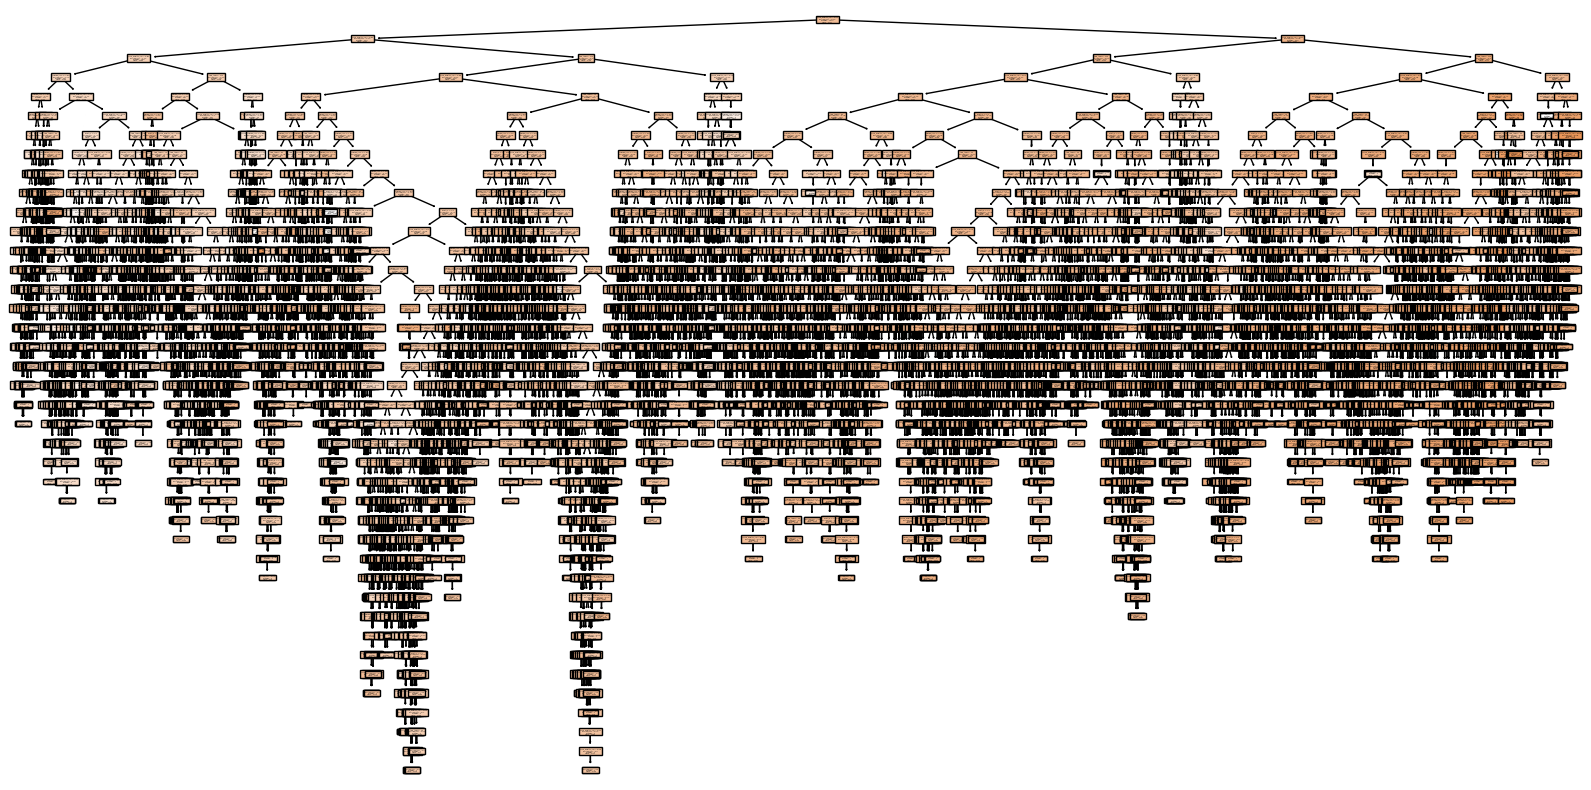

In [126]:
from sklearn.tree import plot_tree
tree = rf_regressor.estimators_[0]

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=['Average_Price', 'Lagged_Quantity_1m', 'time_trend', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11'], filled=True)
plt.show()

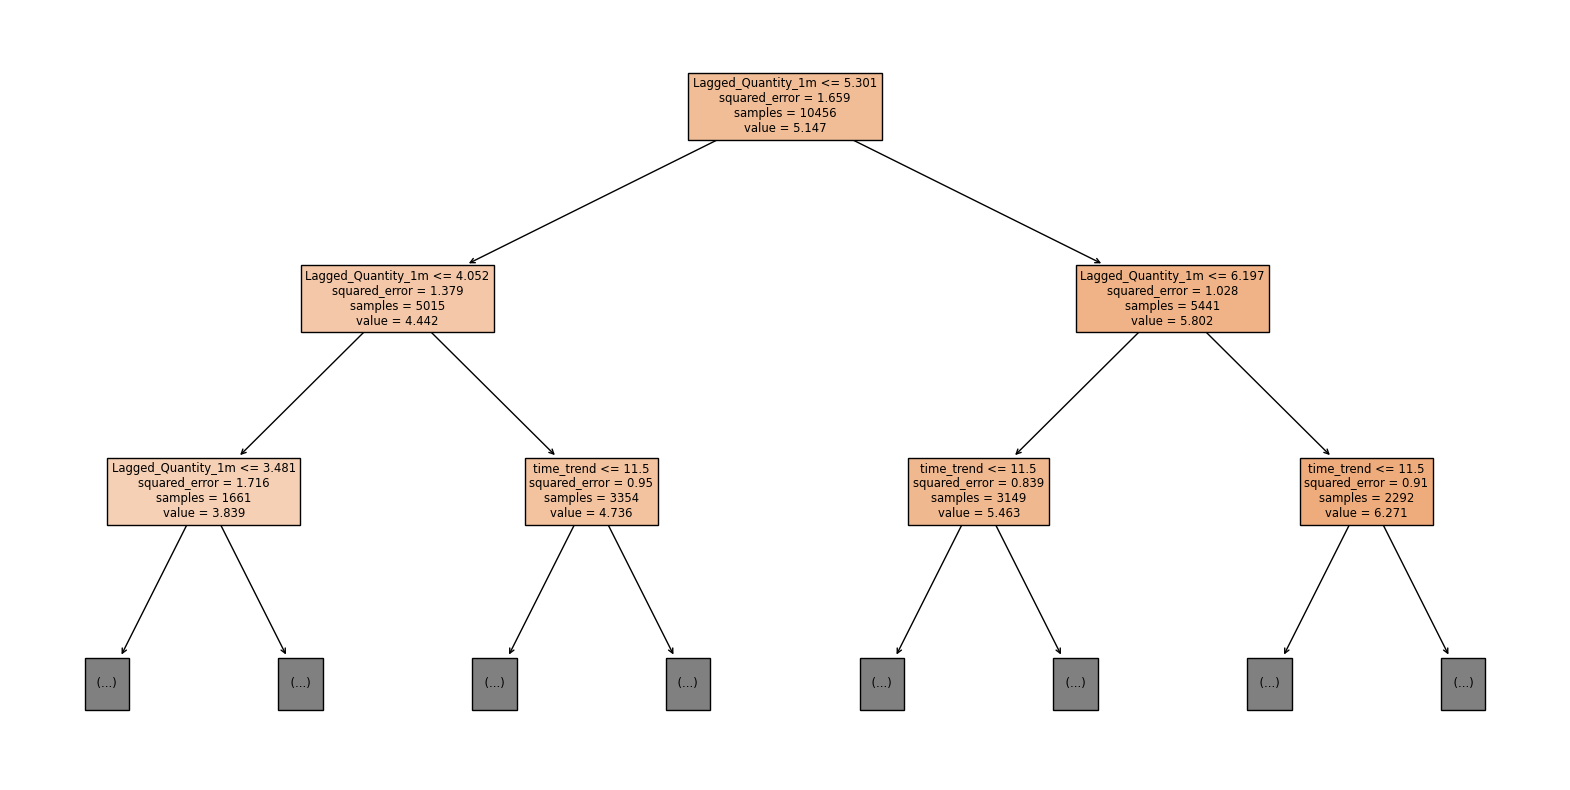

In [127]:
plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=['Average_Price', 'Lagged_Quantity_1m', 'time_trend', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11'], filled=True, max_depth=2)
plt.show()

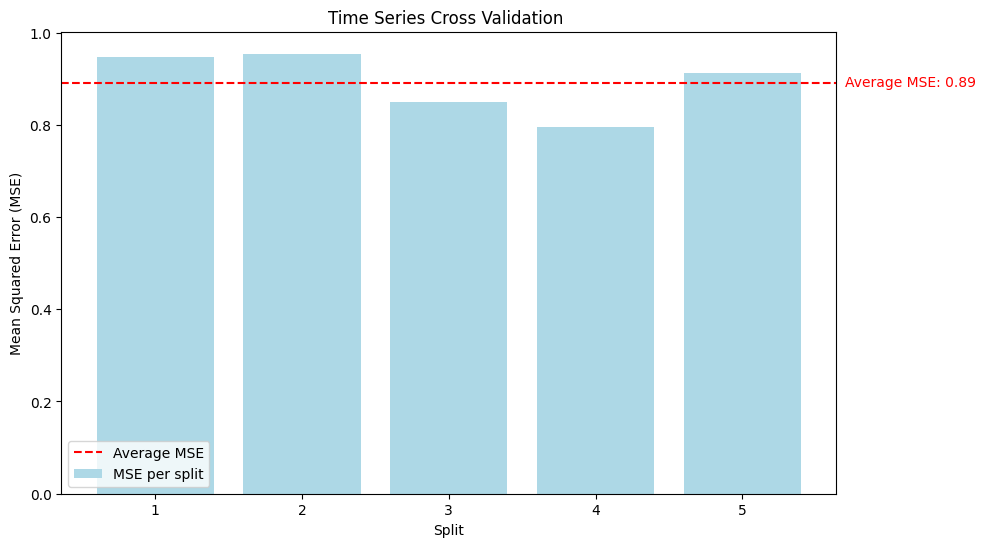

In [128]:
mse_scores = [0.9476114638857321, 0.9539935747101546, 0.8491227263925578, 0.7942281043969683, 0.9113591682929848]

# Calculate average MSE across all splits
average_mse = np.mean(mse_scores)

# Plotting bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(1,len(mse_scores)+1), mse_scores, color='lightblue', label='MSE per split')
plt.axhline(average_mse, color='red', linestyle='--', label='Average MSE')
plt.xlabel('Split')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Time Series Cross Validation ')
plt.text(len(mse_scores) + 0.7, average_mse, f'Average MSE: {average_mse:.2f}', color='red', va='center')
plt.legend()
plt.show()


In [129]:
# Getting predictions for 2011 for Random Forest

In [130]:
x_train = data_2010[['Average_Price','Lagged_Quantity_1m', 'time_trend','month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11']]
y_train= data_2010['Log_Total_Quantity']

In [131]:
x_test = data_2011[['Average_Price','Lagged_Quantity_1m', 'time_trend', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11']]

In [132]:
y_test = data_2011['Log_Total_Quantity']

In [133]:
# Fit Random Forest model
rf_regressor = RandomForestRegressor(n_estimators=1000, max_depth=1700, random_state=42)
rf_regressor.fit(x_train, y_train)

# Make predictions
y_pred_rf = rf_regressor.predict(x_test)

In [134]:
data_2011['Predicted_Value_RF'] = y_pred_rf

<ipython-input-134-88d66c006490>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2011['Predicted_Value_RF'] = y_pred_rf
